# MNIST Classification with a Neural Network
***
In this script, a neural network consisting of **one input layer (784 Neurons), three hidden layers (128/72/72 Neurons), and one output layer (10 Neurons)**. 
The input are the grayscale pixel values of 28x28 images of handwritten digits. The output neurons indicate to which of the 10 digit classes (0 - 9) the input is expected to belong. The network is trained in a classic stochastic gradient descent manner, with sigmoids as activation functions and the sum of squared errors of prediction (SSE) is the loss function which is optimised.

In [1]:
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
eta = 0.01 # Learning rate
#Initialise the five weight matrices (784/128/72 + Bias Unit)
W1 = np.random.uniform(-1, 1, (785, 128))
W2 = np.random.uniform(-1, 1, (129, 72))
W3 = np.random.uniform(-1, 1, (73, 72))
W4 = np.random.uniform(-1, 1, (73, 72))
W5 = np.random.uniform(-1, 1, (73, 10))

First, we define the required functions

In [3]:
def activation(x):
    x = np.clip(x, -500, 500)
    return 1/(1+np.exp(-x))
def d_activation(x):
    y = activation(x)
    return y*(1-y)
def d_error(y_hat, y):
    return (y_hat-y)

A forward pass consists of matrix-multiplication of the respective weight matrix and the previous output, followed by a pointwise activation

In [4]:
def forward_pass(x):
    x = np.append(x, 1)
    sum1 = np.dot(x, W1)
    ac1 = activation(sum1)
    ac1 = np.append(ac1, 1)
    sum2 = np.dot(ac1, W2)
    ac2 = activation(sum2)
    ac2 = np.append(ac2, 1)
    sum3 = np.dot(ac2, W3)
    ac3 = activation(sum3)
    ac3 = np.append(ac3, 1)
    sum4 = np.dot(ac3, W4)
    ac4 = activation(sum4)
    ac4 = np.append(ac4, 1)
    sum5 = np.dot(ac4, W5)
    y_hat = activation(sum5)

    return sum1, ac1, sum2, ac2, sum3, ac3, sum4, ac4, sum5, y_hat

We can define the **delta functions** for the neurons (except for the input layer) which enables us to define a backward pass again in the form of a vector multiplication

In [5]:
def calc_delta5(sum5, y_hat, y_vector):
    delta = np.zeros((10,))
    for i, y in enumerate(y_vector):
        delta[i] = d_error(y_hat[i], y)*d_activation(sum5[i])
    return delta
def calc_delta4(sum4, delta5):
    delta = np.dot(W5[:-1][:], delta5)*d_activation(sum4)
    return delta

def calc_delta3(sum3, delta4):
    delta = np.dot(W4[:-1][:], delta4)*d_activation(sum3)
    return delta

def calc_delta2(sum2, delta3):
    delta = np.dot(W3[:-1][:], delta3)*d_activation(sum2)
    return delta

def calc_delta1(sum1, delta2):
    delta = np.dot(W2[:-1][:], delta2)*d_activation(sum1)
    return delta    

By using these delta functions, the backward pass is just the consecutive application of the outer product between the previous activation and the respective delta functions 

In [6]:
def backward_pass(x, ac1, ac2, ac3, ac4, sum1, sum2, sum3, sum4, sum5, y_hat, y):
    x = np.append(x, 1)
    
    delta5 = calc_delta5(sum5, y_hat, y)
    delta4 = calc_delta4(sum4, delta5)
    delta3 = calc_delta3(sum3, delta4)    
    delta2 = calc_delta2(sum2, delta3)    
    delta1 = calc_delta1(sum1, delta2)
    
    dW5 = np.outer(ac4, delta5)  
    dW4 = np.outer(ac3, delta4)      
    dW3 = np.outer(ac2, delta3)  
    dW2 = np.outer(ac1, delta2)
    dW1 = np.outer(x, delta1)
    
    return dW1, dW2, dW3, dW4, dW5

We use the simplest method of updating the weights

In [7]:
def update_weights(dW1, dW2, dW3, dW4, dW5):
    global W1, W2, W3, W4, W5
    W1 = W1 - eta*dW1
    W2 = W2 - eta*dW2
    W3 = W3 - eta*dW3
    W4 = W4 - eta*dW4
    W5 = W5 - eta*dW5

In [8]:
def calc_y(label):
    return np.identity(10)[int(label)]
def calc_y_hat(y_hat):
    return np.argmax(y_hat)

Now, we can import some data

In [9]:
my_data = genfromtxt('mnist_train.csv', delimiter=',')

In [10]:
my_data_test = genfromtxt('mnist_test.csv', delimiter=',')

In [11]:
data_train = my_data[:, 1:]
data_label = my_data[:, 0]
data_test = my_data_test[:, 1:]
data_test_label = my_data_test[:, 0]

# Training
***
In the training phase, we run over the data set 50-times and update the weights after each forward/backward pass (stochastic gradient descent).

In [12]:
for j in range(50):
    for i in range(len(data_train)):
        data_x = data_train[i, :]
        data_y = calc_y(data_label[i])
        sum1, ac1, sum2, ac2, sum3, ac3, sum4, ac4, sum5, y_hat = forward_pass(data_x)
        dW1, dW2, dW3, dW4, dW5 = backward_pass(data_x, ac1, ac2, ac3, ac4, sum1, sum2, sum3, sum4, sum5, y_hat, data_y)
        update_weights(dW1, dW2, dW3, dW4, dW5)

Finally, we can have a look how well our algorithm performs and create a confusion matrix to get a better overview over the result

acc 0.8934


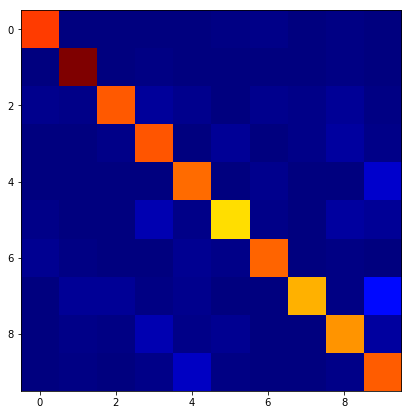

In [13]:
corr = 0 
conf = np.zeros((10, 10))
for i in range(len(data_test)):
    data_x = data_test[i, :]
    label = data_test_label[i]
    _, _, _, _, _, _, _, _, _, y_hat = forward_pass(data_x)
    label_hat = calc_y_hat(y_hat)
    conf[int(label)][label_hat] += 1
    if label == label_hat:
        corr += 1
acc = corr / len(data_test)
print('acc', acc)

plt.figure(figsize=(10, 7))
plt.imshow(conf, cmap=plt.cm.jet)
plt.show()